# Candidate Assignment - Best Buy

## Import Libraries

In [449]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Read the dataset and explore

In [450]:
df = pd.read_excel('Data Science Assignment.xlsx', engine='openpyxl')
df

,week,product,orders,brand,views,cart_adds,price,inventory
0,12/8/2019,A,41.0,Big Cable Brand,4181.0,209.0,34.99,158
1,12/15/2019,A,36.0,Big Cable Brand,3228.0,114.0,29.99,122
2,12/22/2019,A,51.0,Big Cable Brand,5259.0,108.0,29.99,71
3,12/29/2019,A,38.0,Big Cable Brand,3574.0,50.0,24.99,33
4,1/5/2020,A,33.0,Big Cable Brand,5970.0,66.0,34.99,0
...,...,...,...,...,...,...,...,...
255,11/1/2020,E,5.0,Little Cable Brand,853.0,21.0,119.99,62
256,11/8/2020,E,4.0,Little Cable Brand,528.0,7.0,139.99,58
257,11/15/2020,E,10.0,Little Cable Brand,846.0,31.0,79.99,48
258,11/22/2020,E,12.0,Little Cable Brand,770.0,24.0,59.99,75


## Clean dataset - check number of rows with null values

In [451]:
df.isnull().any().sum()

4

In [452]:
# Remove the row since there is just one with null values
df = df.dropna()

## Create new column - dayofyear and drop week column

In [453]:
df['week'] = pd.to_datetime(df['week'])
df['dayofyear'] = df.week.dt.dayofyear
# df = df[['product','dayofyear','orders','views','cart_adds','price','inventory']]
df = df.drop(columns = ['week','brand'])

In [454]:
df

,product,orders,views,cart_adds,price,inventory,dayofyear
0,A,41.0,4181.0,209.0,34.99,158,342
1,A,36.0,3228.0,114.0,29.99,122,349
2,A,51.0,5259.0,108.0,29.99,71,356
3,A,38.0,3574.0,50.0,24.99,33,363
4,A,33.0,5970.0,66.0,34.99,0,5
...,...,...,...,...,...,...,...
255,E,5.0,853.0,21.0,119.99,62,306
256,E,4.0,528.0,7.0,139.99,58,313
257,E,10.0,846.0,31.0,79.99,48,320
258,E,12.0,770.0,24.0,59.99,75,327


## Check for correlation between all features (except the product)

<AxesSubplot:>

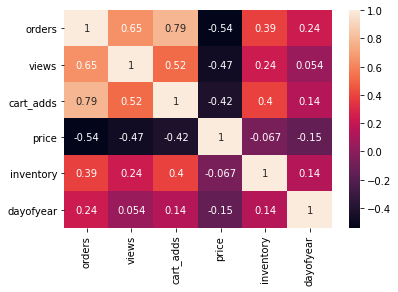

In [455]:
sns.heatmap(df.loc[:, df.columns!='product'].corr(), annot=True)

## Encode product column into integer type

In [460]:
le = LabelEncoder()
df['product'] = le.fit_transform(df['product'])

In [461]:
df

,product,orders,views,cart_adds,price,inventory,dayofyear
0,0,41.0,4181.0,209.0,34.99,158,342
1,0,36.0,3228.0,114.0,29.99,122,349
2,0,51.0,5259.0,108.0,29.99,71,356
3,0,38.0,3574.0,50.0,24.99,33,363
4,0,33.0,5970.0,66.0,34.99,0,5
...,...,...,...,...,...,...,...
255,4,5.0,853.0,21.0,119.99,62,306
256,4,4.0,528.0,7.0,139.99,58,313
257,4,10.0,846.0,31.0,79.99,48,320
258,4,12.0,770.0,24.0,59.99,75,327


## Here we are predicting number of orders based on other features

In [462]:
y = df['orders']
X = df.drop(columns = ['orders'])

In [463]:
X

,product,views,cart_adds,price,inventory,dayofyear
0,0,4181.0,209.0,34.99,158,342
1,0,3228.0,114.0,29.99,122,349
2,0,5259.0,108.0,29.99,71,356
3,0,3574.0,50.0,24.99,33,363
4,0,5970.0,66.0,34.99,0,5
...,...,...,...,...,...,...
255,4,853.0,21.0,119.99,62,306
256,4,528.0,7.0,139.99,58,313
257,4,846.0,31.0,79.99,48,320
258,4,770.0,24.0,59.99,75,327


## Splitting dataset into train and test sets

In [606]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)

## Loading data into xgboost dmatrices

In [607]:
matrix_train = xgb.DMatrix(X_train, label = y_train)
matrix_test = xgb.DMatrix(X_test, label = y_test)

## Here we are using XGBRegressor to predict number of orders

In [608]:
estimator = xgb.XGBRegressor(
    objective= 'reg:squarederror',
    nthread=4,
    seed=42
)

In [609]:
parameters = {
    'max_depth': range (2, 10, 1),
    'min_child_weight': range(1,10,1),
    'eta': range(0,1),
    'learning_rate': [0.1, 0.01, 0.05]
}

## Using GridSearchCV to find the right set of hyperparameters

In [610]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'neg_mean_squared_error',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [611]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs...4,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, seed=42,
                                    subsample=None, tree_method=None,
    

In [612]:
grid_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=6, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, nthread=4, num_parallel_tree=1,
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [613]:
model = grid_search.best_estimator_

In [614]:
y_pred = model.predict(X_test)

## Predictions vs Actual values

In [622]:
print('Predictions:\n', y_pred)

Predictions:
 [13.121443  27.15257   17.217587  14.991595  11.764394  12.741135
  4.682284  12.172971  10.416517  11.615946  34.362114   3.0900443
 38.654316  10.547321  19.651264   8.512359   5.7794485  2.4032278
 30.779984  10.170203   7.3936977  3.3793883  7.5641384 26.172598
 11.706251   5.636172 ]


In [628]:
print('Actual Values:\n', list(y_test.values))

Actual Values:
 [15.0, 35.0, 18.0, 19.0, 12.0, 12.0, 5.0, 11.0, 11.0, 12.0, 30.0, 4.0, 42.0, 8.0, 25.0, 10.0, 5.0, 2.0, 32.0, 9.0, 7.0, 3.0, 8.0, 21.0, 12.0, 8.0]


## Calculate Performance of model using RMSLE (Root Mean Squared Logarthmic Error)

In [617]:
from sklearn.metrics import mean_squared_error

In [618]:
mean_squared_log_error(list(y_test),list(y_pred))

0.02085555591922408

## Visualize Tree (first one) in the trained XGBoost model

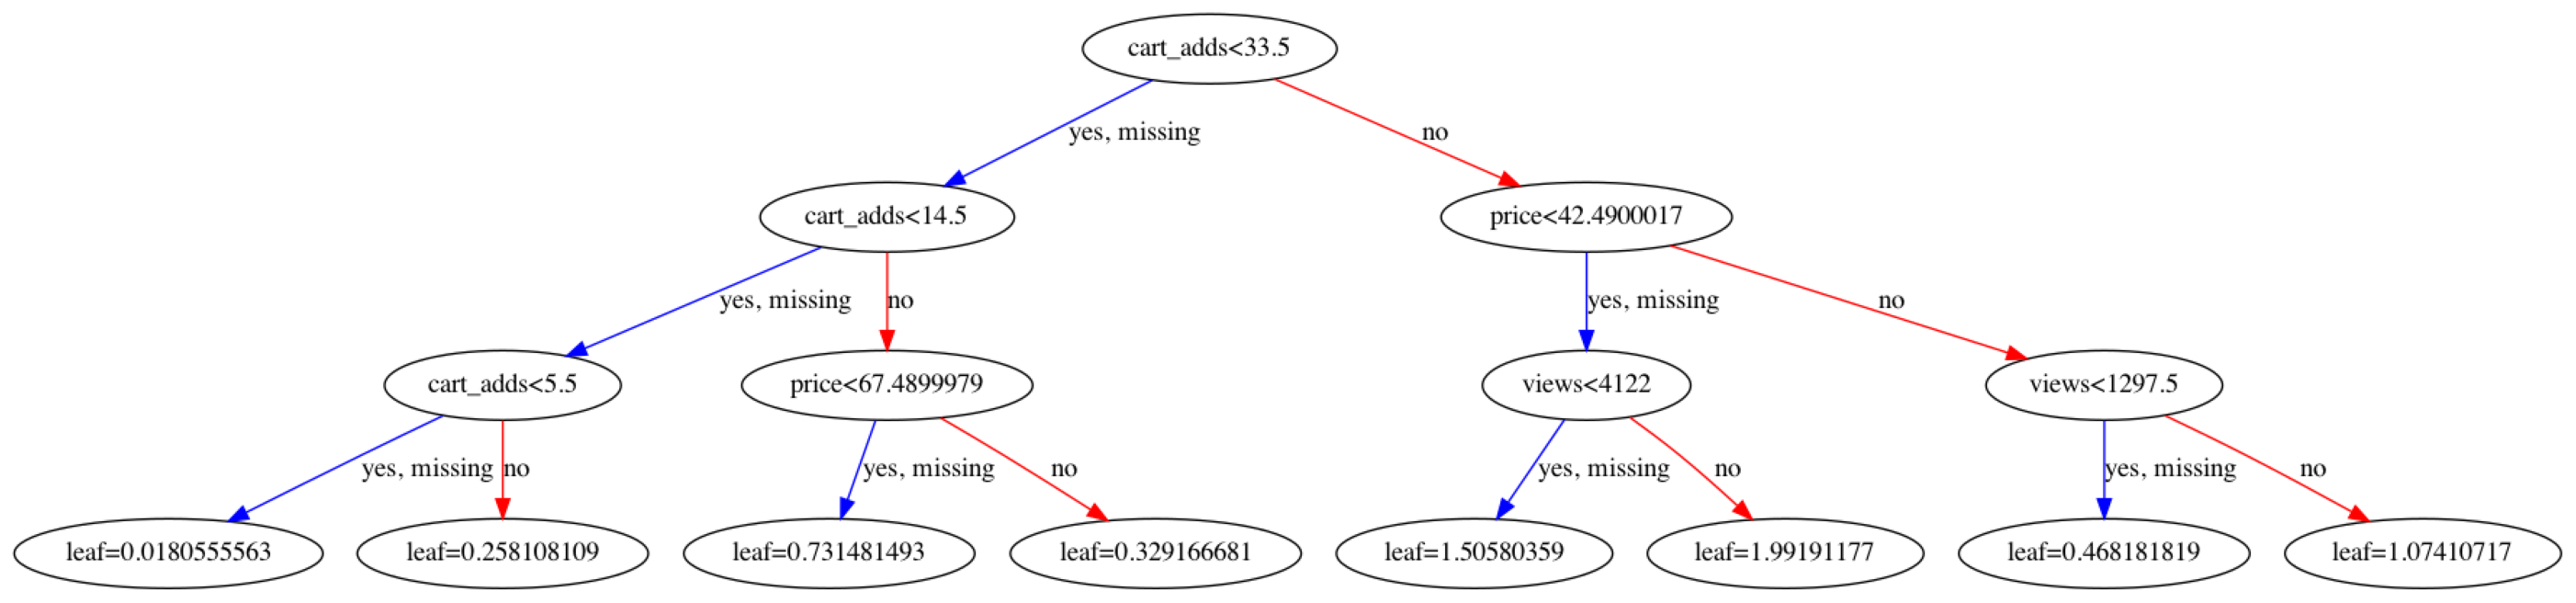

In [619]:
from xgboost import plot_tree
fig, ax = plt.subplots(figsize=(50, 50))
plot_tree(model, ax=ax)
plt.show()

## Feature importances 

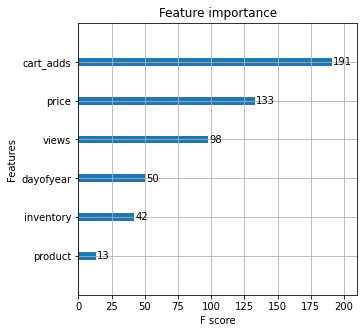

In [620]:
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()